# Практическое домашнее задание 1. Поиск похожих изображений с помощью SVD.

Версия от 08.02.2024.

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения — поиск "хорошего" базиса (eigenfaces) в наборе изображений и использования его для поиска похожих изображений.

**Замечание:** пользоваться циклами по изображениям **запрещено**, если это явно не прописано в условии.

Для этого сначала загрузим набор изображений, на котором будем обучаться. Это набор фотографий лиц, взятый с [сайта](http://vis-www.cs.umass.edu/lfw/) проекта "Labeled faces in the wild". Скачайте лица людей с именами, начинающимися на "А" и положите в папку `data/` в рабочей директории ноутбука.

Импортируем необходимые библиотеки и загрузим картинки в виде numpy-массивов.

In [40]:
import matplotlib.pyplot as plt
import PIL
import tarfile
import os
import numpy as np

def load_images(targz, size):
    images = {}
    tar = tarfile.open(targz, "r:gz")
    for tarinfo in tar:
        if tarinfo.isreg():
            file = tar.extractfile(tarinfo)
            image = PIL.Image.open(file)
            image = image.convert("L")
            image = image.resize(size, PIL.Image.LANCZOS)
            image = np.asarray(image, dtype=np.double)
            image /= np.linalg.norm(image)
            parts = os.path.normpath(tarinfo.name).split(os.path.sep)
            images.setdefault(parts[-2], []).append(image)
    return images

In [41]:
size = 256
images = load_images("data/lfw-a.tgz", (size, size))

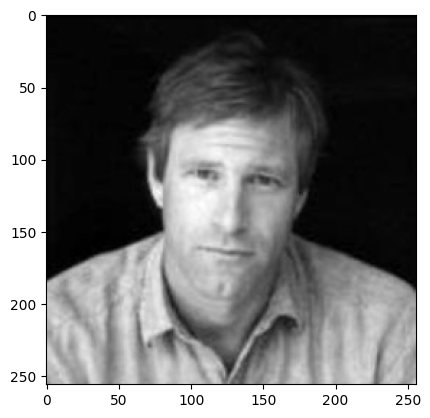

In [42]:
_ = plt.imshow(images["Aaron_Eckhart"][0], cmap="gray")

Сразу отложим одно изображение для последующего поиска.



In [43]:
test_image = images["Alejandro_Toledo"][10]
del images["Alejandro_Toledo"][10]

### a. Применение базового алгоритма SVD (35 баллов)

1. **(4 балла)** С помощью функции ```np.reshape(...)``` получите из словаря `images` массив ```M``` размера ```(size * size, nframes)```, каждым столбцом которого является изображение размера ```(size, size)```, представленное в виде вектора длины ```size**2``` (используйте такое значение параметра `order`, чтобы обходить картинки по столбцам).

*В этом пункте (и только в этом) можно использовать цикл по изображениям.*

In [51]:
M = np.empty((size*size, 0))
for i in images:
  for j in images[i]:
    M = np.hstack((M, np.reshape(j, (-1,1))))

2. **(10 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd``` и постройте график сингулярных чисел, отсортированных по убыванию. Шкала с сингулярными числами должна быть логарифмической. Например, для этого можно использовать функцию ```plt.semilogy```.

    **Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел.

[]

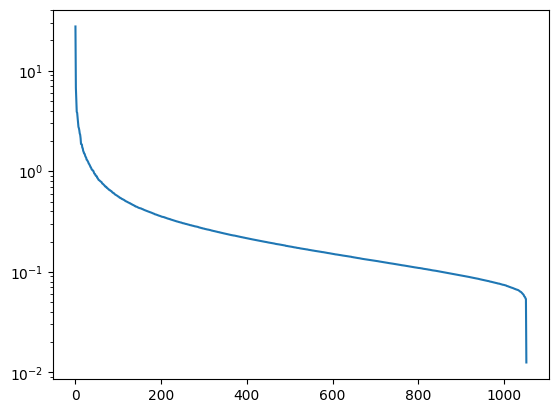

In [52]:
m_sigmas = np.linalg.svd(M, full_matrices = False, compute_uv=False)
x = range(0, len(m_sigmas))
plt.plot(x, m_sigmas)
plt.semilogy()

 3. **(5 баллов)** Заполните пропуск в следующей функции, которая должна визуализировать вектор-столбцы нашей матрицы в виде таблицы. Затем с её помощью визуализируйте несколько первых сингулярных векторов. Опишите неформально, за что отвечают три старших сингулярных вектора.

In [53]:
def plot_as_images(mat, rows, cols):
    '''
        Visualize images from the columns of mat in a table of shape (rows, cols).

        Input
            mat: numpy array of shape (size * size, rows * cols)
            rows: number of rows in the table
            cols: number of columns in the table
    '''

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2,rows*2))
    for i in range(rows):
        for j in range(cols):
            axes[i,j].imshow(mat[:,i*cols + j].reshape((size, size)), cmap="gray")
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)

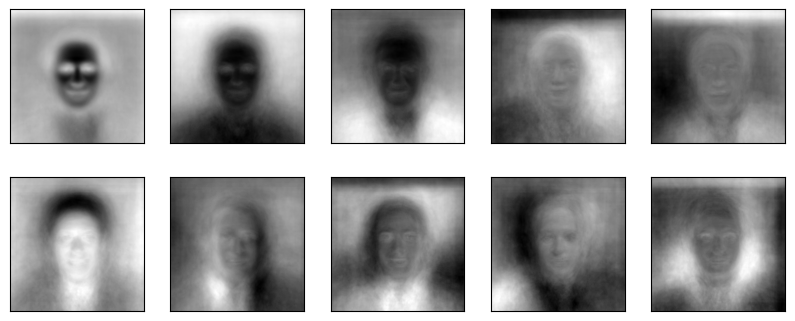

In [54]:
u, s, vh = np.linalg.svd(M, full_matrices = False, compute_uv=True)
plot_as_images(u, 2, 5)

Первый - контуры лица

Второй - свето-тень лица

Третий - контраст лица и фона

4. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая вычисляет оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга. Функция должна возвращать матрицы $U$ и $C$ такие, что столбцы матрицы $U$ составляют ортонормированный базис столбцов $M_{r}$, а $UC = M_{r}$. Также функция `trunc_svd` возвращает **относительную** точность приближения во Фробениусовой норме, т.е.
$$
    \frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для вычисления относительной точности используйте только полученные из сингулярного разложения сингулярные числа.

In [55]:
from functools import reduce
def trunc_svd(M, r):
    '''
        Input
            M: original 2D numpy array
            r: rank value for truncation

        Output
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            rel_eps: relative error of rank-r approximation Mr
    '''
    u, s, vh = np.linalg.svd(M, full_matrices = False, compute_uv=True)
    ur = u[:, :r]
    vhr = vh[:r, :]
    sr = s[:r]
    c = np.diag(sr)@vhr
    rel_eps = (reduce(lambda x, y : x + y*y, s, 0) - reduce(lambda x, y : x + y*y, sr, 0))**0.5 / (reduce(lambda x, y : x + y*y, s, 0))**0.5
    return ur, c, rel_eps



5. **(6 баллов)** Проверим работу написанной функции. Для этого воспользуемся функцией, которая рисует исходное изображение, приближение некоторого ранга, а также первые `count` сингулярных векторов в разложении вместе с их коэффициентами. Заполните пропуски в ней с помощью метода `reshape`.

In [56]:
def plot_as_combination(M, U, C, count, indices):
    '''
        Input
            M: original 2D numpy array
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            count: desired number of images of singular vectors
            indices: indices of columns of M which are visualized
    '''

    fig, all_axes = plt.subplots(len(indices), count + 2, figsize=(count * 2, len(indices)*2))

    for i, index in enumerate(indices):
        axes = all_axes[i, :]

        axes[0].imshow(np.reshape(M[:, index], (size, size)), cmap="gray") # Original image
        axes[0].set_xlabel("Orig")

        appr = U @ C[:, index]
        axes[1].imshow(np.reshape(appr, (size, size)), cmap="gray") # Approximation image
        axes[1].set_xlabel("Appr")

        for j in range(count):
            axes[2 + j].imshow(np.reshape(U[:, j], (size, size)), cmap="gray") # i-th singular vector image
            axes[2 + j].set_xlabel("{:.7}".format(C[j, index]))

        for ax in axes:
            ax.set_xticks([])
            ax.get_yaxis().set_visible(False)

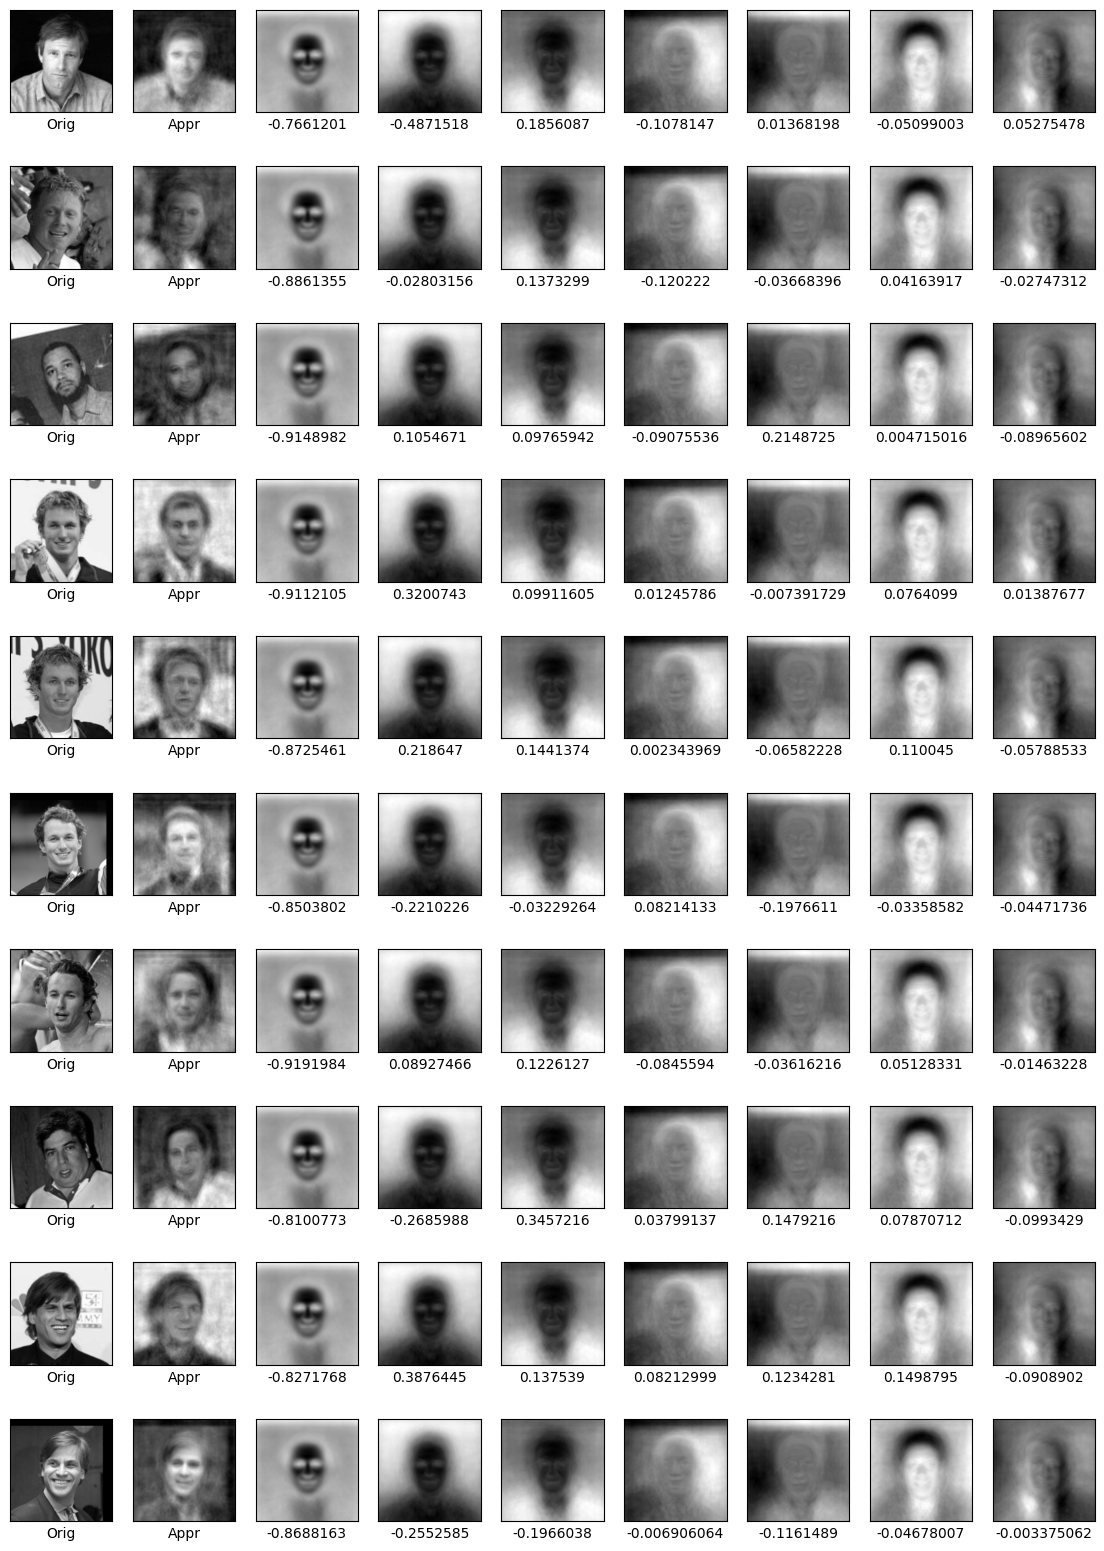

In [57]:
U, C, eps = trunc_svd(M, 100)
plot_as_combination(M, U, C, 7, range(10))

### b. Применение рандомизированного алгоритма SVD (35 баллов)

Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого (кубического) роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений.

1. **(20 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + p``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы **не вычисляете** в явном виде матрицу $QQ^*$.

In [58]:
def rand_svd(M, r, p=10):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            p: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    k = r + p
    omega = np.random.randn(M.shape[1], k)
    y = M @ omega
    q, r = np.linalg.qr(y)
    Mr = q@(np.matrix.getH(q)@M)
    rel_eps = np.linalg.norm(M - Mr)/np.linalg.norm(M)
    return Mr, rel_eps

2. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M_{SVD} - M||_F} - 1
$$
в зависимости от $p$ для $r=50$. По $p$ выберите сетку $[0, 100]$ с шагом 5.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу.

In [59]:
U, C, eps = trunc_svd(M, 50)

[]

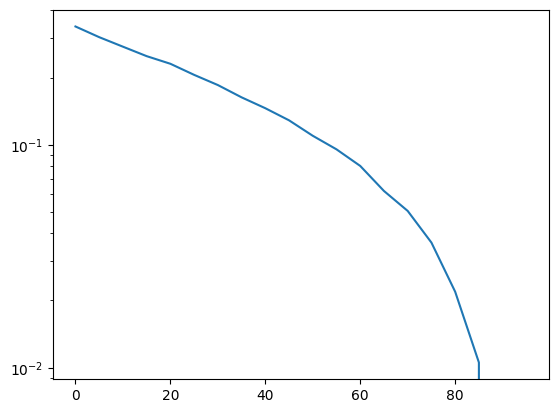

In [60]:
p = range(0, 100, 5)
f = [sum([rand_svd(M, 50, i)[1]/eps - 1 for j in range(10)])/10 for i in p]
plt.plot(p, f)
plt.semilogy()

3. **(5 баллов)** С помощью ```%timeit``` сравните время расчета для ```trunc_svd``` и ```rand_svd``` для ранга $r = 50$. Во сколько раз рандомизированный алгоритм быстрее ```np.linalg.svd``` для матрицы ```M```?

In [61]:
%timeit -n 1 -r 1 _ = trunc_svd(M, 50)
%timeit -n 1 -r 1 _ = rand_svd(M, 50)

30.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### c. Поиск нового изображения (30 баллов)

Представьте, что нам выдали новое изображение `new`, которого в нашей базе нет. Чтобы найти в базе похожие, можно посчитать норму разности с каждым имеющимся изображением. Для проверки напишем вспомогательную функцию, которая будет показывать подписанные картинки.

In [62]:
def show_images(M, indices, names):
    fig, axes = plt.subplots(1, len(indices), figsize=(len(indices)*3, 3))
    for ax, index in zip(axes, indices):
        ax.imshow(M[:,index].reshape((size, size), order="F"), cmap="gray")
        ax.get_xaxis().set_ticks([])
        ax.set_xlabel(names[index])
        ax.get_yaxis().set_visible(False)

   1. **(10 баллов)** Напишите функцию, находящее ближайшее во фробениусовой норме изображение.

In [66]:
def get_norm(v, im):
  return np.linalg.norm(v - im)
def get_closest_naive(M, new_v, count):
    """
        Input
            M: matrix of vectorized images
            new_v: new image as a vector of shape (size**2,)
            count: desired number of closest images

        Output
            indices: list of count indices of closest images
    """


    sort_close = np.argsort(np.apply_along_axis(get_norm, 0, M, new_v))
    return sort_close[:count]

Проверим её на тестовом изображении. Как минимум один Алехандро Толедо должен найтись.

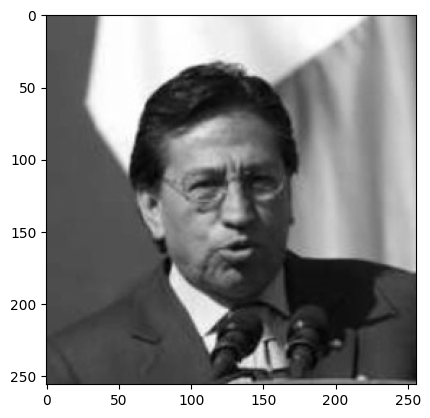

In [67]:
new = test_image
_ = plt.imshow(new, cmap="gray")

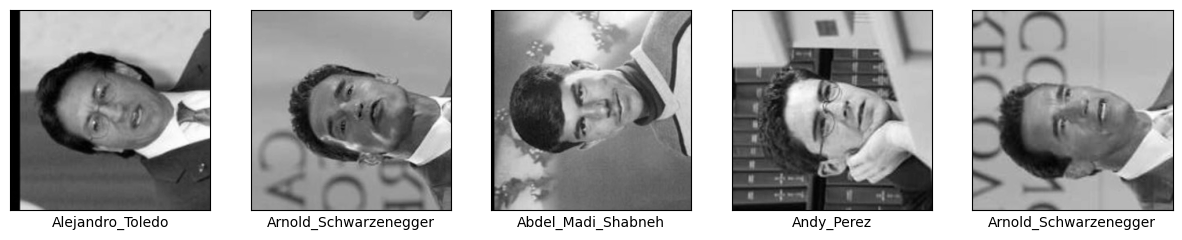

In [68]:
new_v = new.ravel(order="F")
names = sum(map(lambda item: [item[0]] * len(item[1]), images.items()), [])
show_images(M, get_closest_naive(M, new_v, 5), names)

Помимо того, что такой подход может оказаться неприемлемым с точки зрения производительности, он также не устойчив:  например, изменение освещения или фона может очень сильно изменить норму разности.

   2. **(20 баллов)** Применим подход, использующий SVD. Именно, спроецируем новое изображение на пространство, задаваемое ортонормированным базисом $U$, и будем сравнивать норму разности проекций. Причём для устойчивости к изменению освещения не будем учитывать первую компоненту в разложении по столбцам матрицы $U$. Напишите функцию `get_closest_proj`, которая возвращает индексы `count` изображений по описанному алгоритму.

In [78]:
def get_closest_proj(U, C, new_v, count):
    """
        Input
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            new_v: new image as a vector of shape (size**2,)
            count: desired number of closest images

        Output
            indices: list (of len `count`) of indices of closest images
    """
    M = U[:, 1:] @ C[1:, :]
    vec = U[:, 1:] @ (U[:, 1:].T @ new_v)
    return get_closest_naive(M, vec, count)

Проверим подход с SVD  том же тестовом изображении. Правильно реализованный метод должен найти как минимум два изображения Алехандро.

In [77]:
U, C, eps = trunc_svd(M, 100)

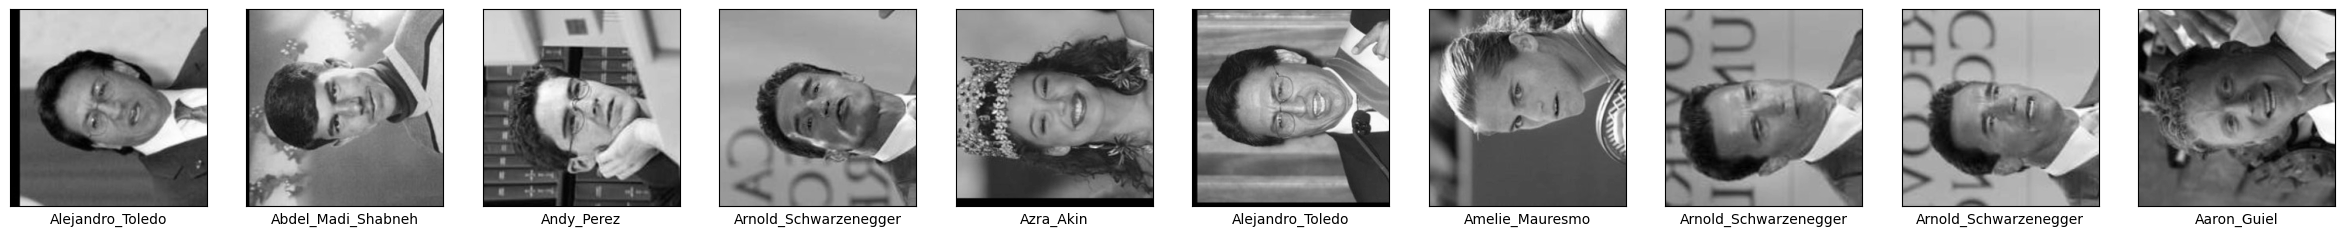

In [79]:
show_images(M, get_closest_proj(U, C, new_v, 10), names)

### c. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.